In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

data_path = "./dataset/datasetTC4.dat"

data = np.loadtxt(data_path)
print(data.shape)
data

(310, 6)


array([[ 63.03,  22.55,  39.61,  40.48,  98.67,  -0.25],
       [ 39.06,  10.06,  25.02,  29.  , 114.41,   4.56],
       [ 68.83,  22.22,  50.09,  46.61, 105.99,  -3.53],
       ...,
       [ 61.45,  22.69,  46.17,  38.75, 125.67,  -2.71],
       [ 45.25,   8.69,  41.58,  36.56, 118.55,   0.21],
       [ 33.84,   5.07,  36.64,  28.77, 123.95,  -0.2 ]])

In [76]:
# Normalização do dataset usando z-score
def z_score_norm(dataset):
    std = np.std(dataset, axis=0)
    normalized = (dataset - np.mean(dataset, axis=0)) / np.where(std == 0, 1e-9, std) # Caso divisão por zero
    return normalized

data = z_score_norm(data)
data

array([[ 0.14722652,  0.50111133, -0.66512805, -0.18460234, -1.44783071,
        -0.70794606],
       [-1.24570706, -0.74889057, -1.45276272, -1.04124965, -0.26402779,
        -0.57967342],
       [ 0.48427345,  0.46808485, -0.0993699 ,  0.27282344, -0.89729467,
        -0.79541679],
       ...,
       [ 0.05541029,  0.51512256, -0.31098936, -0.31369641,  0.58283504,
        -0.77354911],
       [-0.88599664, -0.88600047, -0.55877847, -0.47711606,  0.04734096,
        -0.69567882],
       [-1.54904929, -1.24829085, -0.82546218, -1.05841244,  0.45347411,
        -0.70661266]])

In [77]:
# Inicialização dos parâmetros
ext_rnds = 100 # Número de rodadas para achar o melhor K pela moda
Kmax = 10 # Número de protótipos
rounds = 30 # Número de rodadas
epochs = 20 # Número de iterações
ref_index = "DB" # Índice de referência para escolha do K

In [78]:
# Implementação do Índice de Dunn, oss outros índices foram usados do Scikit-learn
def dunn_index(data, labels):
    min_intercluster_dists = np.max(pairwise_distances(data, metric='euclidean'))
    max_intracluster_dists = 0.0
    
    for cluster_label in np.unique(labels):
        cluster_points = data[labels == cluster_label]
        
        if cluster_label < len(np.unique(labels)) - 1:
            not_cluster_points = data[labels > cluster_label]
            intercluster_dists = pairwise_distances(cluster_points, not_cluster_points, metric='euclidean')
            min_intercluster_dists = min(np.min(intercluster_dists), min_intercluster_dists)
            
        intracluster_dists = pairwise_distances(cluster_points, metric='euclidean')
        max_intracluster_dists = max(np.max(intracluster_dists), max_intracluster_dists)

    return min_intercluster_dists / max_intracluster_dists

In [79]:
# Batch K-means
def kmeans(data, proto, epochs):
    N, p = data.shape
    K = proto.shape[0]
    SSD = np.zeros(epochs)

    updt_proto = np.copy(proto)
    
    for epoch in range(epochs):
        dist = np.zeros((N, K))
        for t in range(N):
            dist[t, :] = np.linalg.norm(data[t, :] - updt_proto, axis=1)
        
        cluster = np.argmin(dist, axis=1)
        SSD[epoch] = np.sum(np.min(dist, axis=1)**2)

        for k in range(K):
            I = np.where(cluster == k)[0]
            partition = data[I, :]
            updt_proto[k, :] = np.mean(partition, axis=0)

    return updt_proto, SSD

In [108]:
# Rodada prévia para encontrar o melhor valor de K por cada índice
k_by_dunn, k_by_ch, k_by_db = [], [], []

for ext_rnd in range(ext_rnds):
    best_dunns, best_chs, best_dbs = [], [], []
    
    for K in range(2, Kmax+1):
        rnd_final_prototypes, rnd_ssds = [], []
        
        for rnd in range(10): # Aplicando K-médias nos dados por rodada
            idxs = np.random.choice(data.shape[0], K, replace=False) # Aleatoriedade dos protótipos
            prototypes = data[idxs, :] # Protótipos definidos
            
            prototypes, kmeans_SSD = kmeans(data, prototypes, epochs) # Aplicando o K-means
            
            rnd_final_prototypes.append(prototypes)
            rnd_ssds.append(kmeans_SSD)
        
        k_best_ssd_idx = np.argmin([ssd[-1] for ssd in rnd_ssds]) # Pega o índice da rodada com menor SSD final
        k_best_final_prototypes = rnd_final_prototypes[k_best_ssd_idx]
    
        labels = np.argmin(cdist(data, k_best_final_prototypes), axis=1) # Cálcula as labels (clusters) de cada amostra
    
        best_dunns.append(dunn_index(data, labels)) # Salvando o Índice de Dunn de K
        best_chs.append(calinski_harabasz_score(data, labels)) # Salvando o Índice de Calinski-Harabasz de K
        best_dbs.append(davies_bouldin_score(data, labels)) # Salvando o Índice de Davies-Bouldin de K
    
    k_by_dunn.append(np.argmax(best_dunns) + 2) # Melhor K segundo o Índice de Dunn
    k_by_ch.append(np.argmax(best_chs) + 2) # Melhor K segundo o Índice de Calinski-Harabasz
    k_by_db.append(np.argmin(best_dbs) + 2) # Melhor K segundo o Índice de Davies-Bouldin
    
    print("Round {}/{} finished".format(ext_rnd + 1, ext_rnds))
    
unique_dunn, counts_dunn = np.unique(k_by_dunn, return_counts=True)
unique_ch, counts_ch = np.unique(k_by_ch, return_counts=True)
unique_db, counts_db = np.unique(k_by_db, return_counts=True)

print("Best K per Round by Dunn Index:", dict(zip(unique_dunn, counts_dunn)))
print("Best K per Round by Calinski-Harabasz Index:", dict(zip(unique_ch, counts_ch)))
print("Best K per Round by Davies-Bouldin Index:", dict(zip(unique_db, counts_db)))

Round 1/100 finished
Round 2/100 finished
Round 3/100 finished
Round 4/100 finished
Round 5/100 finished
Round 6/100 finished
Round 7/100 finished
Round 8/100 finished
Round 9/100 finished
Round 10/100 finished
Round 11/100 finished
Round 12/100 finished
Round 13/100 finished
Round 14/100 finished
Round 15/100 finished
Round 16/100 finished
Round 17/100 finished
Round 18/100 finished
Round 19/100 finished
Round 20/100 finished
Round 21/100 finished
Round 22/100 finished
Round 23/100 finished
Round 24/100 finished
Round 25/100 finished
Round 26/100 finished
Round 27/100 finished
Round 28/100 finished
Round 29/100 finished
Round 30/100 finished
Round 31/100 finished
Round 32/100 finished
Round 33/100 finished
Round 34/100 finished
Round 35/100 finished
Round 36/100 finished
Round 37/100 finished
Round 38/100 finished
Round 39/100 finished
Round 40/100 finished
Round 41/100 finished
Round 42/100 finished
Round 43/100 finished
Round 44/100 finished
Round 45/100 finished
Round 46/100 finish

In [80]:
# Rodar novamente usando o melhor K (moda) pelo índice escolhido
if ref_index == "Dunn":
    k_mode = unique_dunn[np.argmax(counts_dunn)]
elif ref_index == "CH":
    k_mode = unique_ch[np.argmax(counts_ch)]
elif ref_index == "DB":
    k_mode = unique_db[np.argmax(counts_db)]

# Aplicando K-médias nos dados por rodada
rnd_prototypes, rnd_final_prototypes, rnd_ssds = [], [], []
for rnd in range(rounds):
    idxs = np.random.choice(data.shape[0], k_mode, replace=False) # Aleatoriedade dos protótipos
    prototypes = data[idxs, :] # Protótipos definidos
    rnd_prototypes.append(prototypes)
    
    prototypes, kmeans_SSD = kmeans(data, prototypes, epochs) # Aplicando o K-means
    
    rnd_final_prototypes.append(prototypes)
    rnd_ssds.append(kmeans_SSD)

k_best_ssd_idx = np.argmin([ssd[-1] for ssd in rnd_ssds]) # Pega o índice da rodada com menor SSD final

k_best_prototypes = rnd_prototypes[k_best_ssd_idx]
k_best_final_prototypes = rnd_final_prototypes[k_best_ssd_idx]
k_best_ssd = rnd_ssds[k_best_ssd_idx]

labels = np.argmin(cdist(data, k_best_final_prototypes), axis=1) # Cálcula as labels (clusters) de cada amostra
dn_index = dunn_index(data, labels) # Índice de Dunn
ch_index = calinski_harabasz_score(data, labels) # Índice de Calinski-Harabasz
db_index = davies_bouldin_score(data, labels) # Índice de Davies-Bouldin

print("Best K (using {} Index) = {}".format(ref_index, k_mode))
print("Dunn Index = {}".format(dn_index))
print("Calinski-Harabasz Index = {}".format(ch_index))
print("Davies-Bouldin Index = {}".format(db_index))
print("Best SSD =", k_best_ssd[-1])

# Posição dos Protótipos:
prototypes_df = pd.DataFrame(k_best_final_prototypes)
print("\nProtótipos:")
print(prototypes_df)

Best K (using DB Index) = 2
Dunn Index = 0.023851090910180957
Calinski-Harabasz Index = 189.33630228445105
Davies-Bouldin Index = 1.1308691932619839
Best SSD = 1151.8966087304477

Protótipos:
          0        1        2         3         4         5
0  0.970127  0.60977  0.88853  0.791059 -0.270898  0.730788
1 -0.664326 -0.41756 -0.60845 -0.541704  0.185506 -0.500431


In [81]:
# Análise Estatística
data_with_clusters = pd.DataFrame(np.hstack((data, np.expand_dims(labels, axis=1))))

for part in range(k_mode):
    data_i_with_clusters = data_with_clusters.loc[data_with_clusters[6] == part]
    
    min_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].min().to_frame().T), index=['min'])
    max_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].max().to_frame().T), index=['max'])
    median_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].median().to_frame().T), index=['median'])
    mean_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].mean().to_frame().T), index=['mean'])
    std_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].std().to_frame().T), index=['std'])
    
    statistics = pd.concat([min_by_feature, max_by_feature, median_by_feature, mean_by_feature, std_by_feature])
    
    print("\nAnálise Estatística - Agrupamento {} ({} amostras):".format(part + 1, len(data_i_with_clusters)))
    print(statistics)


Análise Estatística - Agrupamento 1 (126 amostras):
               0         1         2         3         4          5
min    -0.172968 -1.228275 -1.048958 -1.765818 -3.598080  -0.795417
max     4.029077  3.191268  3.984562  5.855955  2.551077  10.460307
median  0.895122  0.365002  0.763573  0.813825 -0.234320   0.650917
mean    0.970127  0.609770  0.888530  0.791059 -0.270898   0.730788
std     0.660458  1.023317  0.792072  0.895941  1.087511   1.180440

Análise Estatística - Agrupamento 2 (184 amostras):
               0         1         2         3         4         5
min    -1.995927 -2.411223 -2.047673 -2.207573 -2.927208 -0.996226
max     0.809698  2.403636  1.412198  1.186929  3.395683  0.763856
median -0.707304 -0.405615 -0.632197 -0.562184  0.199641 -0.622342
mean   -0.664326 -0.417560 -0.608450 -0.541704  0.185506 -0.500431
std     0.551626  0.739857  0.591301  0.647906  0.894997  0.350257


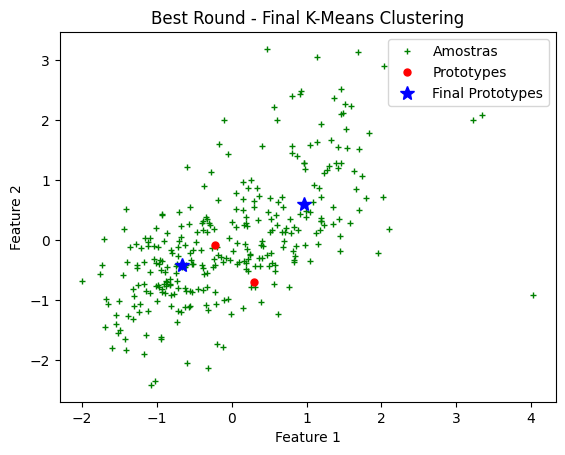

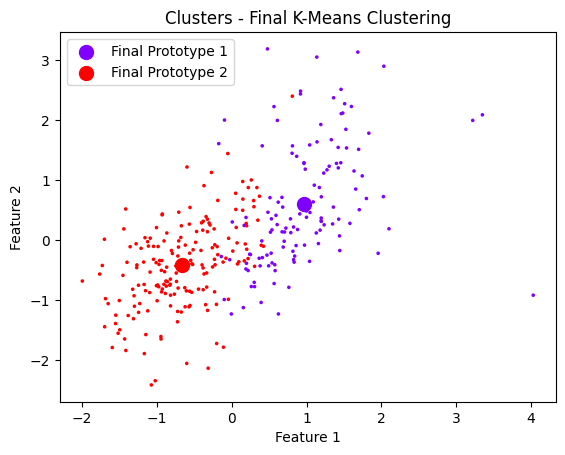

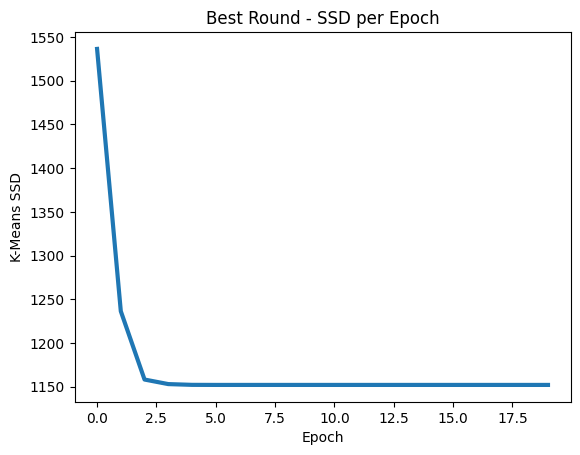

In [82]:
# Mostra posição final dos protótipos
plt.figure()
# vor = Voronoi(kmeans_prototypes[:,:2])
# fig = voronoi_plot_2d(vor)
plt.plot(data[:, 0], data[:, 1], '+g', markersize=5)
plt.plot(k_best_prototypes[:, 0], k_best_prototypes[:, 1], '.r', markersize=10)
plt.plot(k_best_final_prototypes[:, 0], k_best_final_prototypes[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Best Round - Final K-Means Clustering')
plt.legend(['Amostras', 'Prototypes', 'Final Prototypes'])
plt.show()

# Mostra os dados em seus respectivos clusters
plt.figure()
cluster_colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
labels_cluster_colors = [cluster_colors[i] for i in labels]
plt.scatter(data[:, 0], data[:, 1], color=labels_cluster_colors, marker='.', s=10)
for idx, cluster in enumerate(cluster_colors):
    cluster_points = k_best_final_prototypes[idx]
    plt.scatter(cluster_points[0], cluster_points[1], color=cluster, marker='o', s=100, label=f'Final Prototype {idx+1}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters - Final K-Means Clustering')
plt.legend()
plt.show()

# Mostra evolução do SSD ao longo das épocas de treinamento
plt.figure()
plt.plot(k_best_ssd, linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('K-Means SSD')
plt.title('Best Round - SSD per Epoch')
plt.show()

In [83]:
# PCA para visualização dos dados
def pca_train(X, num_components):
    n = X.shape[0]

    Cx = (X.T @ X) / n # Matriz de covariância
    
    eigenvalues, eigenvectors = np.linalg.eig(Cx)
    
    idxs = eigenvalues.argsort()[::-1] # Índices do maior para o menor
    eigenvalues = np.sort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idxs] # Montagem de autovetores

    var = np.cumsum(eigenvalues) / np.sum(eigenvalues) # variancia explicada

    Vq = eigenvectors[:, :num_components] # Matriz com q primeiros autovetores

    return Vq, num_components, var

# Função para aplicar a transformação nos dados
def pca_transform(Vq, X):
    Z = X @ Vq # Transformação
    return Z

In [84]:
# Aplicação do PCA para visualização
Vq, _, _ = pca_train(data, 2) # Gerando matriz de transformação
data_pca = pca_transform(Vq, data) # Dados transformados pelo PCA
k_best_prototypes_pca = pca_transform(Vq, k_best_prototypes) # Protótipos transformados pelo PCA
k_best_final_prototypes_pca = pca_transform(Vq, k_best_final_prototypes) # Protótipos finais transformados pelo PCA

print(data_pca.shape, k_best_prototypes_pca.shape, k_best_final_prototypes_pca.shape)

# Posição dos Protótipos:
prototypes_pca_df = pd.DataFrame(k_best_final_prototypes_pca)
print("\nProtótipos:")
print(prototypes_pca_df)

(310, 2) (2, 2) (2, 2)

Protótipos:
          0         1
0 -1.824836  0.010536
1  1.249616 -0.007215


In [85]:
# Análise Estatística
data_with_clusters = pd.DataFrame(np.hstack((data_pca, np.expand_dims(labels, axis=1))))

for part in range(k_mode):
    data_i_with_clusters = data_with_clusters.loc[data_with_clusters[2] == part]
    
    min_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].min().to_frame().T), index=['min'])
    max_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].max().to_frame().T), index=['max'])
    median_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].median().to_frame().T), index=['median'])
    mean_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].mean().to_frame().T), index=['mean'])
    std_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].std().to_frame().T), index=['std'])
    
    statistics = pd.concat([min_by_feature, max_by_feature, median_by_feature, mean_by_feature, std_by_feature])
    
    print("\nAnálise Estatística - Agrupamento {} ({} amostras):".format(part + 1, len(data_i_with_clusters)))
    print(statistics)


Análise Estatística - Agrupamento 1 (126 amostras):
               0         1
min    -8.928824 -3.084487
max    -0.278297  3.819538
median -1.787322 -0.142263
mean   -1.824836  0.010536
std     1.130308  1.398195

Análise Estatística - Agrupamento 2 (184 amostras):
               0         1
min    -0.252801 -2.533840
max     3.632675  2.228523
median  1.271795  0.034277
mean    1.249616 -0.007215
std     0.873358  0.829539


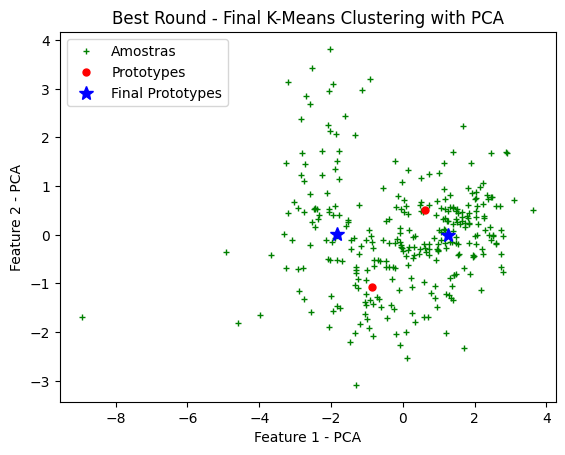

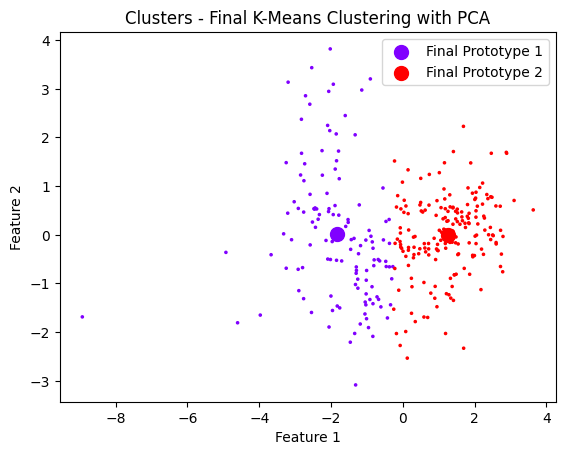

In [86]:
# Mostra posição final dos protótipos com PCA
plt.figure()
# vor = Voronoi(kmeans_prototypes[:,:2])
# fig = voronoi_plot_2d(vor)
plt.plot(data_pca[:, 0], data_pca[:, 1], '+g', markersize=5)
plt.plot(k_best_prototypes_pca[:, 0], k_best_prototypes_pca[:, 1], '.r', markersize=10)
plt.plot(k_best_final_prototypes_pca[:, 0], k_best_final_prototypes_pca[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1 - PCA')
plt.ylabel('Feature 2 - PCA')
plt.title('Best Round - Final K-Means Clustering with PCA')
plt.legend(['Amostras', 'Prototypes', 'Final Prototypes'])
plt.show()

# Mostra os dados em seus respectivos clusters
plt.figure()
cluster_colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
labels_cluster_colors = [cluster_colors[i] for i in labels]
plt.scatter(data_pca[:, 0], data_pca[:, 1], color=labels_cluster_colors, marker='.', s=10)
for idx, cluster in enumerate(cluster_colors):
    cluster_points = k_best_final_prototypes_pca[idx]
    plt.scatter(cluster_points[0], cluster_points[1], color=cluster, marker='o', s=100, label=f'Final Prototype {idx+1}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters - Final K-Means Clustering with PCA')
plt.legend()
plt.show()

In [87]:
# Batch K-medians
def kmedians(data, proto, epochs):
    N, p = data.shape
    K = proto.shape[0]
    SSD = np.zeros(epochs)
    
    updt_proto = np.copy(proto)
    
    for epoch in range(epochs):
        dist = np.zeros((N, K))
        for t in range(N):
            dist[t, :] = np.sum(np.abs(data[t, :] - updt_proto), axis=1)
        
        cluster = np.argmin(dist, axis=1)
        SSD[epoch] = np.sum(np.min(dist, axis=1)**2)
    
        for k in range(K):
            I = np.where(cluster == k)[0]
            partition = data[I, :]
            updt_proto[k, :] = np.median(partition, axis=0)

    return updt_proto, SSD

In [88]:
# Rodar novamente usando o melhor K (moda) pelo índice escolhido
if ref_index == "Dunn":
    k_mode = unique_dunn[np.argmax(counts_dunn)]
elif ref_index == "CH":
    k_mode = unique_ch[np.argmax(counts_ch)]
elif ref_index == "DB":
    k_mode = unique_db[np.argmax(counts_db)]

# Aplicando K-medianas nos dados por rodada
rnd_prototypes, rnd_final_prototypes, rnd_ssds = [], [], []
for rnd in range(rounds):
    idxs = np.random.choice(data.shape[0], k_mode, replace=False) # Aleatoriedade dos protótipos
    prototypes = data[idxs, :] # Protótipos definidos
    rnd_prototypes.append(prototypes)
    
    prototypes, kmedians_SSD = kmedians(data, prototypes, epochs) # Aplicando o K-medians
    
    rnd_final_prototypes.append(prototypes)
    rnd_ssds.append(kmedians_SSD)

k_best_ssd_idx = np.argmin([ssd[-1] for ssd in rnd_ssds]) # Pega o índice da rodada com menor SSD final

k_best_prototypes = rnd_prototypes[k_best_ssd_idx]
k_best_final_prototypes = rnd_final_prototypes[k_best_ssd_idx]
k_best_ssd = rnd_ssds[k_best_ssd_idx]

labels = np.argmin(cdist(data, k_best_final_prototypes), axis=1) # Cálcula as labels (clusters) de cada amostra
dn_index = dunn_index(data, labels) # Índice de Dunn
ch_index = calinski_harabasz_score(data, labels) # Índice de Calinski-Harabasz
db_index = davies_bouldin_score(data, labels) # Índice de Davies-Bouldin

print("Best K (using {} Index) = {}".format(ref_index, k_mode))
print("Dunn Index = {}".format(dn_index))
print("Calinski-Harabasz Index = {}".format(ch_index))
print("Davies-Bouldin Index = {}".format(db_index))
print("Best SSD =", k_best_ssd[-1])

# Posição dos Protótipos:
prototypes_df = pd.DataFrame(k_best_final_prototypes)
print("\nProtótipos:")
print(prototypes_df)

Best K (using DB Index) = 2
Dunn Index = 0.0331980231801332
Calinski-Harabasz Index = 185.8456555773498
Davies-Bouldin Index = 1.1320506184425543
Best SSD = 4594.9188317103235

Protótipos:
          0         1         2         3         4         5
0  0.817834  0.305955  0.651555  0.759351 -0.279070  0.442507
1 -0.732001 -0.408618 -0.698059 -0.615911  0.248151 -0.630609


In [89]:
# Análise Estatística
data_with_clusters = pd.DataFrame(np.hstack((data, np.expand_dims(labels, axis=1))))

for part in range(k_mode):
    data_i_with_clusters = data_with_clusters.loc[data_with_clusters[6] == part]
    
    min_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].min().to_frame().T), index=['min'])
    max_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].max().to_frame().T), index=['max'])
    median_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].median().to_frame().T), index=['median'])
    mean_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].mean().to_frame().T), index=['mean'])
    std_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].std().to_frame().T), index=['std'])
    
    statistics = pd.concat([min_by_feature, max_by_feature, median_by_feature, mean_by_feature, std_by_feature])
    
    print("\nAnálise Estatística - Agrupamento {} ({} amostras):".format(part + 1, len(data_i_with_clusters)))
    print(statistics)


Análise Estatística - Agrupamento 1 (144 amostras):
               0         1         2         3         4          5
min    -0.561734 -2.131999 -1.048958 -1.765818 -3.598080  -0.810084
max     4.029077  3.191268  3.984562  5.855955  2.551077  10.460307
median  0.809408  0.310459  0.632931  0.754874 -0.258011   0.459575
mean    0.844125  0.486426  0.806911  0.721233 -0.296906   0.627942
std     0.709318  1.056693  0.785890  0.876788  1.067162   1.150608

Análise Estatística - Agrupamento 2 (166 amostras):
               0         1         2         3         4         5
min    -1.995927 -2.411223 -2.047673 -2.207573 -2.533109 -0.996226
max     0.809698  2.403636  0.862095  0.759351  3.395683  0.440374
median -0.743623 -0.410119 -0.752043 -0.618896  0.249279 -0.633276
mean   -0.732253 -0.421960 -0.699971 -0.625648  0.257557 -0.544721
std     0.530506  0.724874  0.531365  0.603947  0.864943  0.297934


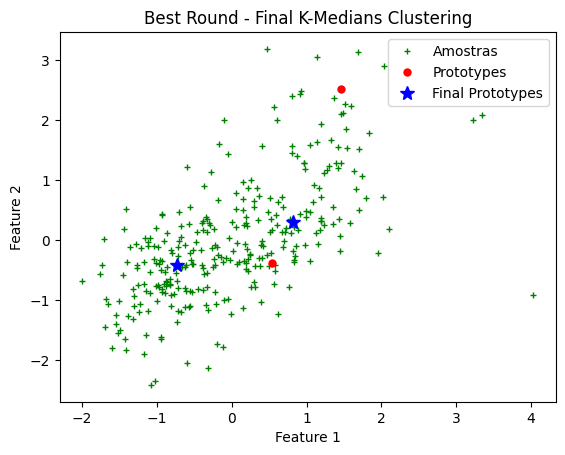

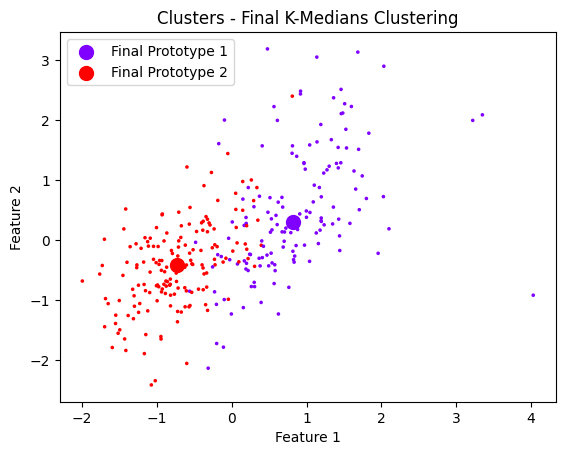

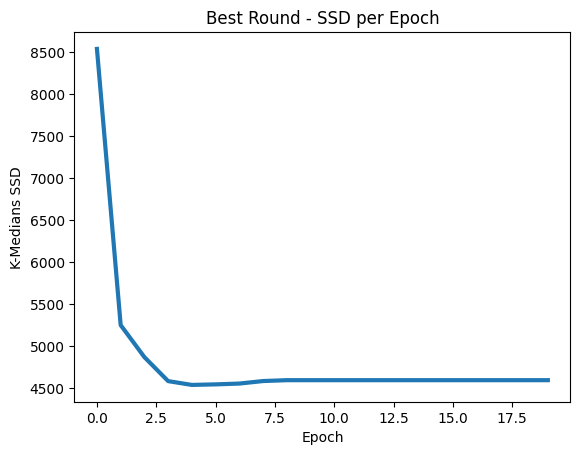

In [90]:
# Mostra posição final dos protótipos
plt.figure()
# vor = Voronoi(kmeans_prototypes[:,:2])
# fig = voronoi_plot_2d(vor)
plt.plot(data[:, 0], data[:, 1], '+g', markersize=5)
plt.plot(k_best_prototypes[:, 0], k_best_prototypes[:, 1], '.r', markersize=10)
plt.plot(k_best_final_prototypes[:, 0], k_best_final_prototypes[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Best Round - Final K-Medians Clustering')
plt.legend(['Amostras', 'Prototypes', 'Final Prototypes'])
plt.show()

# Mostra os dados em seus respectivos clusters
plt.figure()
cluster_colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
labels_cluster_colors = [cluster_colors[i] for i in labels]
plt.scatter(data[:, 0], data[:, 1], color=labels_cluster_colors, marker='.', s=10)
for idx, cluster in enumerate(cluster_colors):
    cluster_points = k_best_final_prototypes[idx]
    plt.scatter(cluster_points[0], cluster_points[1], color=cluster, marker='o', s=100, label=f'Final Prototype {idx+1}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters - Final K-Medians Clustering')
plt.legend()
plt.show()

# Mostra evolução do SSD ao longo das épocas de treinamento
plt.figure()
plt.plot(k_best_ssd, linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('K-Medians SSD')
plt.title('Best Round - SSD per Epoch')
plt.show()

In [91]:
# Aplicação do PCA para visualização
Vq, _, _ = pca_train(data, 2) # Gerando matriz de transformação
data_pca = pca_transform(Vq, data) # Dados transformados pelo PCA
k_best_prototypes_pca = pca_transform(Vq, k_best_prototypes) # Protótipos transformados pelo PCA
k_best_final_prototypes_pca = pca_transform(Vq, k_best_final_prototypes) # Protótipos finais transformados pelo PCA

print(data_pca.shape, k_best_prototypes_pca.shape, k_best_final_prototypes_pca.shape)

# Posição dos Protótipos:
prototypes_pca_df = pd.DataFrame(k_best_final_prototypes_pca)
print("\nProtótipos:")
print(prototypes_pca_df)

(310, 2) (2, 2) (2, 2)

Protótipos:
          0         1
0 -1.401313 -0.211737
1  1.421249  0.043125


In [92]:
# Análise Estatística
data_with_clusters = pd.DataFrame(np.hstack((data_pca, np.expand_dims(labels, axis=1))))

for part in range(k_mode):
    data_i_with_clusters = data_with_clusters.loc[data_with_clusters[2] == part]
    
    min_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].min().to_frame().T), index=['min'])
    max_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].max().to_frame().T), index=['max'])
    median_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].median().to_frame().T), index=['median'])
    mean_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].mean().to_frame().T), index=['mean'])
    std_by_feature = pd.DataFrame(np.array(data_i_with_clusters.iloc[:,:-1].std().to_frame().T), index=['std'])
    
    statistics = pd.concat([min_by_feature, max_by_feature, median_by_feature, mean_by_feature, std_by_feature])
    
    print("\nAnálise Estatística - Agrupamento {} ({} amostras):".format(part + 1, len(data_i_with_clusters)))
    print(statistics)


Análise Estatística - Agrupamento 1 (144 amostras):
               0         1
min    -8.928824 -3.084487
max     0.123743  3.819538
median -1.458190 -0.188395
mean   -1.609109 -0.069848
std     1.202557  1.375227

Análise Estatística - Agrupamento 2 (166 amostras):
               0         1
min    -0.143617 -2.330205
max     3.632675  2.228523
median  1.394629  0.097662
mean    1.395854  0.060591
std     0.790500  0.772875


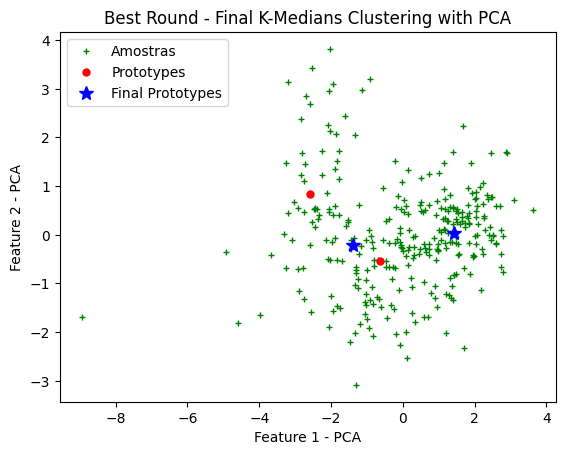

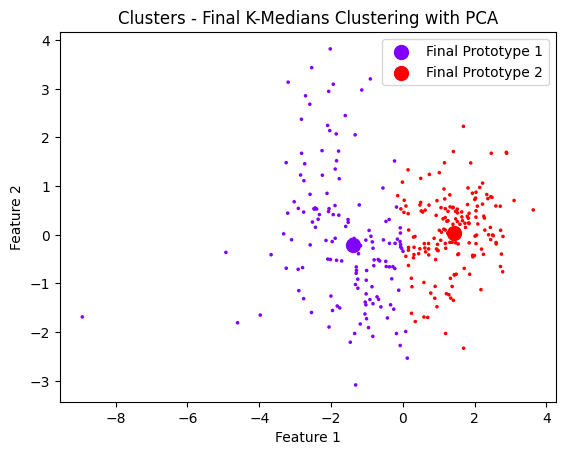

In [93]:
# Mostra posição final dos protótipos com PCA
plt.figure()
# vor = Voronoi(kmedians_prototypes[:,:2])
# fig = voronoi_plot_2d(vor)
plt.plot(data_pca[:, 0], data_pca[:, 1], '+g', markersize=5)
plt.plot(k_best_prototypes_pca[:, 0], k_best_prototypes_pca[:, 1], '.r', markersize=10)
plt.plot(k_best_final_prototypes_pca[:, 0], k_best_final_prototypes_pca[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1 - PCA')
plt.ylabel('Feature 2 - PCA')
plt.title('Best Round - Final K-Medians Clustering with PCA')
plt.legend(['Amostras', 'Prototypes', 'Final Prototypes'])
plt.show()

# Mostra os dados em seus respectivos clusters
plt.figure()
cluster_colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
labels_cluster_colors = [cluster_colors[i] for i in labels]
plt.scatter(data_pca[:, 0], data_pca[:, 1], color=labels_cluster_colors, marker='.', s=10)
for idx, cluster in enumerate(cluster_colors):
    cluster_points = k_best_final_prototypes_pca[idx]
    plt.scatter(cluster_points[0], cluster_points[1], color=cluster, marker='o', s=100, label=f'Final Prototype {idx+1}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters - Final K-Medians Clustering with PCA')
plt.legend()
plt.show()